In [1]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import matplotlib.patches as patches
import os,torch
import pandas as pd
from pathlib import Path
from torchvision import models
import matplotlib.pyplot as plt

In [49]:
# from transformers import AutoImageProcessor, ViTMAEForPreTraining
# from PIL import Image
# import requests
# model = ViTMAEForPreTraining.from_pretrained('facebook/vit-mae-base')

In [2]:
import models_vit

In [3]:
import os,sys
sys.path.append('/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Code/Yufeng/multimodal_CXR_Note')
from util.pos_embed import interpolate_pos_embed

In [4]:
ROOT = '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Processed/Yufeng/PediXR_Results'

In [5]:
DATASET_DIR="/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/vindr-pcxr/1.0.0" 

In [162]:
# model == densnet
# SAVE_DIR=os.path.join(ROOT,"results")
# _model_name = os.path.join(SAVE_DIR,'checkpoint-74.pth')
# checkpoint = torch.load(_model_name,map_location='cpu')
# model = models.__dict__['densenet121'](num_classes=6)
# model.load_state_dict(checkpoint['model'])
# # model.eval()
# target_layers = [model.features.denseblock4]
# cam = GradCAM(model=model, target_layers=target_layers)

In [6]:
# model == vits
SAVE_DIR=os.path.join(ROOT,"vit-b_CXR_0.5M_mae_CheXpert")
_model_name = os.path.join(SAVE_DIR,'checkpoint-74.pth')
model = models_vit.__dict__['vit_base_patch16'](
            img_size=224,
            num_classes=6,
            drop_rate=0,
            drop_path_rate=0.2,
            global_pool=False,
        )
checkpoint = torch.load(_model_name,map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]
interpolate_pos_embed(model, checkpoint_model)
model.load_state_dict(checkpoint_model, strict=False)
target_layers = [model.blocks[-1].norm1]
cam = GradCAM(model=model, target_layers=target_layers)

In [7]:
class PediCXRDataset(torch.utils.data.Dataset):
    def __init__(self,data_dir, phase, transform, merge_disease = True,seed = 42):
        np.random.seed(seed)  # Reset the seed so all runs are the same.
        # '/nfs/turbo/med-kayvan-lab/Projects/HeartFailure/Data/Raw/physionet.org/files/vindr-pcxr/1.0.0'
        self.dir_root = data_dir
        self.set_type = phase
        self.transform = transform
        self.label_columns = ['Brocho-pneumonia','Bronchiolitis','Bronchitis','CPAM',
                              'Congenital emphysema','Diagphramatic hernia','Hyaline membrane disease','Lung tumor',
                              'Mediastinal tumor','No finding','Other disease','Pleuro-pneumonia','Pneumonia','Situs inversus','Tuberculosis']

        # generate labels
        meta_file_name = f'image_labels_{self.set_type}.csv'
        annotation_file_name = f'annotations_{self.set_type}.csv'
        self.meta_df = pd.read_csv(os.path.join(self.dir_root,meta_file_name))
        self.labels = self.meta_df[self.label_columns]
        self.labels = self.labels.fillna(0)
        self.labels = self.labels.replace(-1, 0)
        
        if merge_disease:
            kept_labels = ['Brocho-pneumonia','Bronchiolitis','Bronchitis','Pneumonia','No finding'] 
            diseases_to_combine = list(set(self.label_columns) - set(kept_labels))
            merged_labels = self.labels.copy()
            merged_labels['Other diseases'] = 0
            for disease in diseases_to_combine:
                if disease in merged_labels.columns:
                    merged_labels['Other diseases'] += merged_labels[disease]
                    merged_labels[disease] = 0
                else:
                    continue
            merged_labels.drop(columns=diseases_to_combine, inplace=True, errors='ignore')
            merged_labels[merged_labels >= 1] = 1
            self.labels = merged_labels

        # generate annotations
        self.anno_df = pd.read_csv(os.path.join(self.dir_root,annotation_file_name))
        self.annotation = self.anno_df[['x_min', 'y_min', 'x_max', 'y_max']]
        
        
        # 
        
    def __len__(self):
        return self.meta_df.shape[0]
    
    def get_img_path(self,idx):
        row = self.meta_df.iloc[idx,:]
        image_name = str((row['image_id'])) + '.jpg'
        image_path = os.path.join(self.dir_root,self.set_type,image_name)
        self.jpg_name = Path(image_path)
        label = self.labels.iloc[idx,:]
        PI = self.annotation.iloc[idx,:]
        return self.jpg_name,label,PI        
        

    def __getitem__(self, idx):

        sample = {}
        sample["idx"] = idx
        
        img_path,label,PI = self.get_img_path(idx)
        sample['label'] = torch.tensor((list(label)),dtype=torch.long)
        sample['PI'] = torch.tensor(list(np.round(PI,3)),dtype=torch.float32)
        sample['img_path'] = img_path.__str__()

        # single channel output renormliazed to [0, 255]
        # img = imread(str(img_path), as_gray=True)
        img = cv2.imread(sample['img_path'])
        # img = cv2.resize(img, (224, 224))
        # img = np.float32(img) / 255
        if self.transform:
            sample["img"] = self.transform(img)
        else: 
            sample["img"] = img
        return sample

In [8]:
mean = [0.5056, 0.5056, 0.5056]
std = [0.252, 0.252, 0.252]

In [9]:
dataset = PediCXRDataset(data_dir=DATASET_DIR, phase='test', transform=None)

In [128]:
# original plot
def plot_original_x_ray_bbox(num_images=):
    for i in range(num_images):
        sample = dataset[i]
        coord = sample['PI']
        print(coord)
        img = sample['img']
        fig, ax = plt.subplots()
        ax.imshow(img)
        rect = patches.Rectangle((coord[0], coord[1]), coord[2]-coord[0], coord[3]-coord[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.show()

tensor([730.8670, 275.0070, 937.8350, 701.9690])


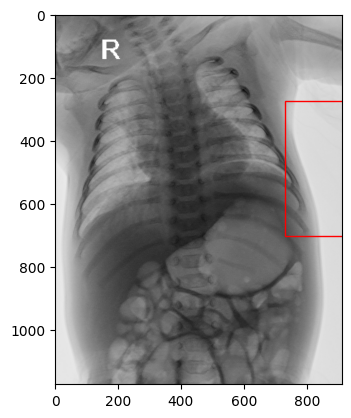

In [25]:
sample = dataset[27]
coord = sample['PI']
print(coord)
img = sample['img']
fig, ax = plt.subplots()
ax.imshow(img)
rect = patches.Rectangle((coord[0], coord[1]), coord[2]-coord[0], coord[3]-coord[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [154]:
# plot_original_x_ray_bbox(10)

In [59]:
# model == vits
m_name = 'vit-s_CXR_0.3M_mae'
SAVE_DIR=os.path.join(ROOT,m_name)
_model_name = os.path.join(SAVE_DIR,'checkpoint-74.pth')
model = models_vit.__dict__['vit_base_patch16'](
            img_size=224,
            num_classes=6,
            drop_rate=0,
            drop_path_rate=0.2,
            global_pool=False,
        )
checkpoint = torch.load(_model_name,map_location='cpu')
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]
interpolate_pos_embed(model, checkpoint_model)
model.load_state_dict(checkpoint_model, strict=False)
model.eval()
target_layers = [model.blocks[-1].norm1]
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)

In [123]:
def return_cam(m_name = 'vit-s_CXR_0.3M_mae'):
    SAVE_DIR=os.path.join(ROOT,m_name)
    _model_name = os.path.join(SAVE_DIR,'checkpoint-74.pth')
    model = models_vit.__dict__['vit_base_patch16'](
                img_size=224,
                num_classes=6,
                drop_rate=0,
                drop_path_rate=0.2,
                global_pool=False,
            )
    checkpoint = torch.load(_model_name,map_location='cpu')
    checkpoint_model = checkpoint['model']
    state_dict = model.state_dict()
    for k in ['head.weight', 'head.bias']:
        if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
            print(f"Removing key {k} from pretrained checkpoint")
            del checkpoint_model[k]
    interpolate_pos_embed(model, checkpoint_model)
    model.load_state_dict(checkpoint_model, strict=False)
    model.eval()
    target_layers = [model.blocks[-1].norm1]
    def reshape_transform(tensor, height=14, width=14):
        result = tensor[:, 1 :  , :].reshape(tensor.size(0),
            height, width, tensor.size(2))
    
        # Bring the channels to the first dimension,
        # like in CNNs.
        result = result.transpose(2, 3).transpose(1, 2)
        return result
    cam = GradCAM(model=model, target_layers=target_layers,reshape_transform=reshape_transform)
    return cam  

In [121]:
model_list = ['vit-b_CXR_0.5M_mae_CheXpert',
             'vit-b_CXR_0.5M_mae_COVIDx',
             'vit-b_CXR_0.5M_mae',
             'vit-s_CXR_0.3M_mae_CheXpert',
             'vit-s_CXR_0.3M_mae_COVIDx',
             'vit-s_CXR_0.3M_mae',
             'vit-s_imagenet_mae',
             'vit-b_imagenet_mae_pretrain','vit-s_imagenet_mae_pretrain',
             'vit-s_CXR_0.3M_mae_pretrain',
             'vit-b_CXR_0.5M_mae_pretrain']

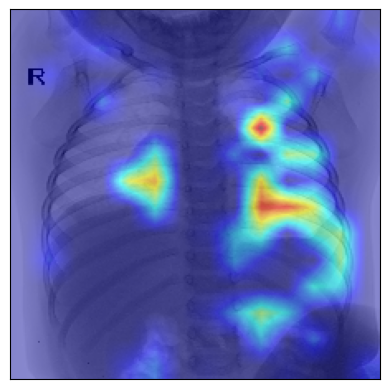

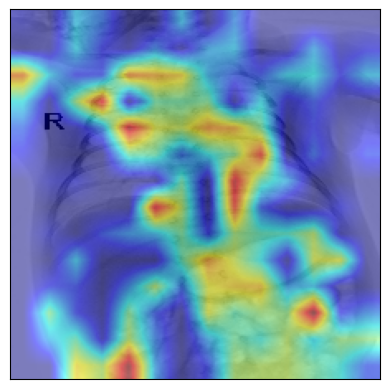

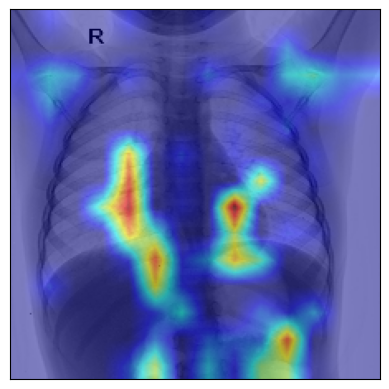

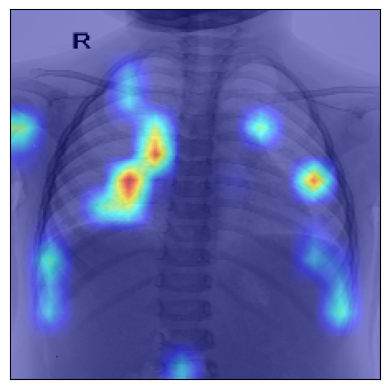

In [124]:
m_name = model_list[-1]
cam = return_cam(m_name)
for i in [1,3,5,9]:
    sample = dataset[i]
    coord = sample['PI']
    img = sample['img']
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    class_idx = np.argmax(dataset.labels.iloc[sample["idx"],])
    targets = [ClassifierOutputTarget(class_idx)]
    input_tensor = preprocess_image(img, mean=mean, std=std)
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    grayscale_cam = np.uint8(255*grayscale_cams[0, :])
    grayscale_cam = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
    # images = np.hstack((np.uint8(255*img), cam_image))
    # images = np.uint8(255*img)
    images = cam_image
    Image.fromarray(cam_image)
    
    fig, ax = plt.subplots()
    ax.imshow(images)
    # reshaped_img_shape = (224, 224, 3)
    # img_shape = sample['img'].shape
    # scale = np.flipud(np.divide(reshaped_img_shape, img_shape))
    # x_min = np.array(coord[0]) * scale[1]
    # x_max = np.array(coord[2]) * scale[1]
    # y_min = np.array(coord[1]) * scale[2]
    # y_max = np.array(coord[3]) * scale[2]
    # rect = patches.Rectangle((x_min, y_min), (x_max-x_min), (y_max-y_min), linewidth=1, edgecolor='r', facecolor='none')
    # ax.add_patch(rect)
    # ax.set_title(f'Visualization of sample {i}')
    ax.set(yticklabels=[]) 
    ax.set(xticklabels=[]) 
    ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left = False,
        labelbottom=False) # labels along the bottom edge are off
    # plt.show()
    if not os.path.isdir(f'./Figs/{m_name}'):
        os.mkdir(f'./Figs/{m_name}')
    plt.savefig(f'./Figs/{m_name}/Visualization of sample {i}',dpi =300, bbox_inches='tight')
# sample 1,3,5,9,15

In [ ]:
# SAVE_DIR=os.path.join(ROOT,"results")
# _model_name = os.path.join(SAVE_DIR,'checkpoint-74.pth')
# checkpoint = torch.load(_model_name,map_location='cpu')
# model = models.__dict__['densenet121'](num_classes=6)
# model.load_state_dict(checkpoint['model'])
# # model.eval()
# target_layers = [model.features.denseblock4]
# cam = GradCAM(model=model, target_layers=target_layers)
# plot_scaled_x_ray_bbox(model,target_layers,)